# Baroclinic adjustment

In this example, we simulate the evolution and equilibration of a baroclinically
unstable front.

## Install dependencies

First let's make sure we have all required packages installed.

In [1]:
using Pkg
Pkg.activate("./")
pkg"add Oceananigans#ss/for-drakkar"
pkg"add GLMakie"
using Oceananigans
using Oceananigans.Units

  Activating project at `~/development/OGS-workshop`
    Updating git-repo `https://github.com/CliMA/Oceananigans.jl.git`
   Resolving package versions...
    Updating `~/development/OGS-workshop/Project.toml`
  [9e8cae18] ~ Oceananigans v0.95.26 `https://github.com/CliMA/Oceananigans.jl.git#ss/for-drakkar` ⇒ v0.95.26 `https://github.com/CliMA/Oceananigans.jl.git#ss/for-drakkar`
    Updating `~/development/OGS-workshop/Manifest.toml`
  [9e8cae18] ~ Oceananigans v0.95.26 `https://github.com/CliMA/Oceananigans.jl.git#ss/for-drakkar` ⇒ v0.95.26 `https://github.com/CliMA/Oceananigans.jl.git#ss/for-drakkar`
Precompiling packages...
    360.9 ms  ✓ Adapt
    433.4 ms  ✓ Blosc_jll
    609.7 ms  ✓ Accessors → IntervalSetsExt
    645.2 ms  ✓ Static
    656.1 ms  ✓ Roots → RootsChainRulesCoreExt
    847.6 ms  ✓ OffsetArrays
    919.4 ms  ✓ Accessors → UnitfulExt
    383.6 ms  ✓ GPUArraysCore
    452.3 ms  ✓ StructArrays → StructArraysAdaptExt
    550.1 ms  ✓ Adapt → AdaptSparseArraysExt
    747.

## Grid

We use a three-dimensional channel that is periodic in the `x` direction:

In [2]:
Lx = 1000kilometers # east-west extent [m]
Ly = 1000kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 48, 8),
                       x = (0, Lx),
                       y = (-Ly/2, Ly/2),
                       z = (-Lz, 0),
                       topology = (Periodic, Bounded, Bounded))

48×48×8 RectilinearGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── Periodic x ∈ [0.0, 1.0e6)          regularly spaced with Δx=20833.3
├── Bounded  y ∈ [-500000.0, 500000.0] regularly spaced with Δy=20833.3
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=125.0

## Model

We built a `HydrostaticFreeSurfaceModel` with an `ImplicitFreeSurface` solver.
Regarding Coriolis, we use a beta-plane centered at 45° South.

In [22]:
model = HydrostaticFreeSurfaceModel(; grid,
                                    coriolis = BetaPlane(latitude = -45),
                                    buoyancy = BuoyancyTracer(),
                                    timestepper = :QuasiAdamsBashforth2,
                                    tracers = :b,
                                    free_surface = ImplicitFreeSurface(),
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO())

HydrostaticFreeSurfaceModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 48×48×8 RectilinearGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: FFTImplicitFreeSurfaceSolver
├── advection scheme: 
│   ├── momentum: WENO(order=5)
│   └── b: WENO(order=5)
└── coriolis: BetaPlane{Float64}

We start our simulation from rest with a baroclinically unstable buoyancy distribution.
We use `ramp(y, Δy)`, defined below, to specify a front with width `Δy`
and horizontal buoyancy gradient `M²`. We impose the front on top of a
vertical buoyancy gradient `N²` and a bit of noise.

In [23]:
"""
    ramp(y, Δy)

Linear ramp from 0 to 1 between -Δy/2 and +Δy/2.

For example:
```
            y < -Δy/2 => ramp = 0
    -Δy/2 < y < -Δy/2 => ramp = y / Δy
            y >  Δy/2 => ramp = 1
```
"""
ramp(y, Δy) = min(max(0, y/Δy + 1/2), 1)

N² = 1e-5 # [s⁻²] buoyancy frequency / stratification
M² = 1e-7 # [s⁻²] horizontal buoyancy gradient

Δy = 100kilometers # width of the region of the front
Δb = Δy * M²       # buoyancy jump associated with the front
ϵb = 1e-2 * Δb     # noise amplitude

bᵢ(x, y, z) = N² * z + Δb * ramp(y, Δy) + ϵb * randn()

set!(model, b=bᵢ)

Let's visualize the initial buoyancy distribution.

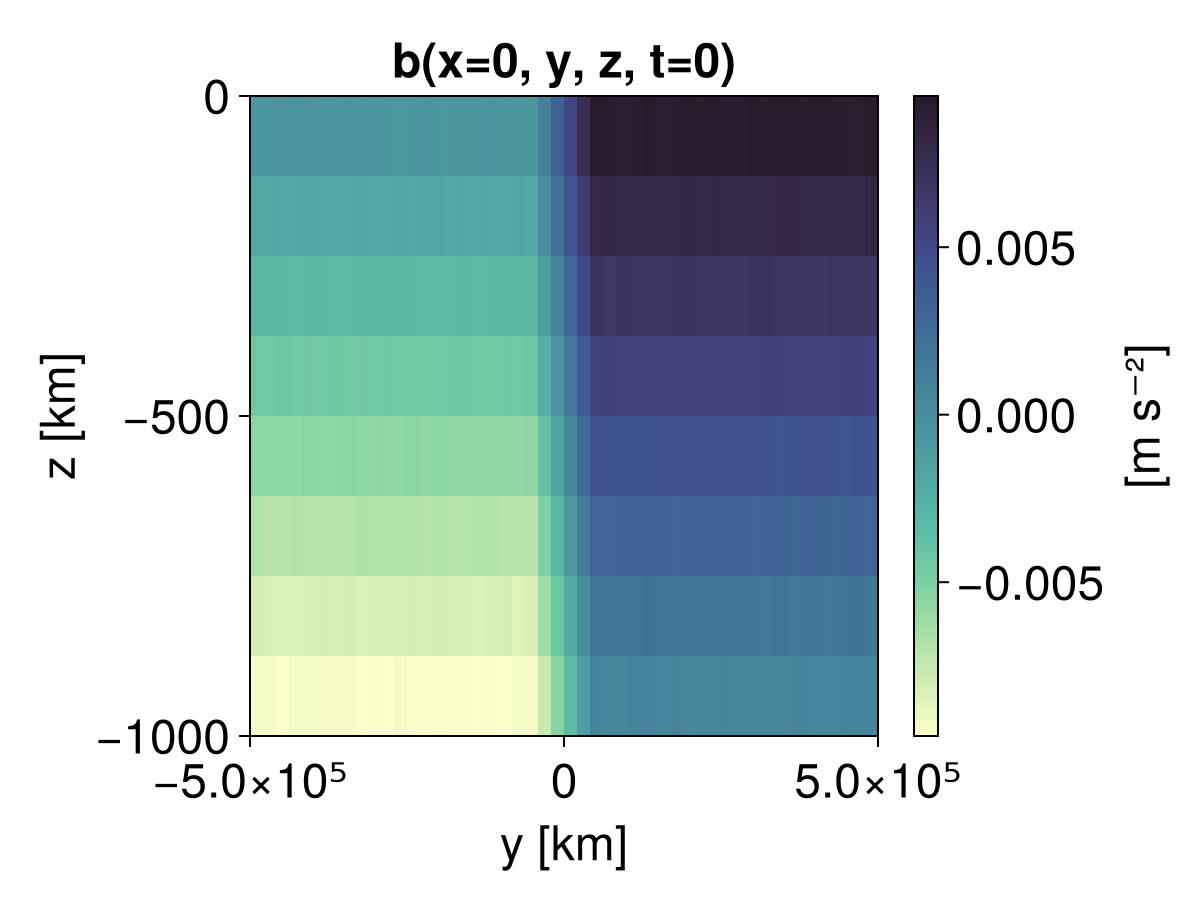

In [24]:
using GLMakie

# Build coordinates with units of kilometers
x, y, z = 1e-3 .* nodes(grid, (Center(), Center(), Center()))

b = model.tracers.b

fig, ax, hm = heatmap(view(b, 1, :, :),
                      colormap = :deep,
                      axis = (xlabel = "y [km]",
                              ylabel = "z [km]",
                              title = "b(x=0, y, z, t=0)",
                              titlesize = 24))

Colorbar(fig[1, 2], hm, label = "[m s⁻²]")

current_figure() #hide
fig

## Simulation

Now let's build a `Simulation`.

In [25]:
simulation = Simulation(model, Δt=40minutes, stop_time=40days)

Simulation of HydrostaticFreeSurfaceModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 40 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 40 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

and add a callback to print a message about how the simulation is going,

In [26]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

## Diagnostics/Output

Here, we save the buoyancy, $b$, at the edges of our domain as well as
the zonal ($x$) average of buoyancy.

In [27]:
u, v, w = model.velocities
ζ = ∂x(v) - ∂y(u)
B = Average(b, dims=1)
U = Average(u, dims=1)
V = Average(v, dims=1)

Average of 48×49×8 Field{Center, Face, Center} on RectilinearGrid on CPU over dims (1,)
└── operand: 48×49×8 Field{Center, Face, Center} on RectilinearGrid on CPU
    └── grid: 48×48×8 RectilinearGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo

We then set up output writers for the east, north, bottom, and top surfaces, as well as zonal averages.

In [28]:
filename = "baroclinic_adjustment"
save_fields_interval = 0.5day

slicers = (east = (grid.Nx, :, :),
           north = (:, grid.Ny, :),
           bottom = (:, :, 1),
           top = (:, :, grid.Nz))

for side in keys(slicers)
    indices = slicers[side]

    simulation.output_writers[side] = JLD2OutputWriter(model, (; b, ζ);
                                                       filename = filename * "_$(side)_slice",
                                                       schedule = TimeInterval(save_fields_interval),
                                                       overwrite_existing = true,
                                                       indices)
end

simulation.output_writers[:zonal] = JLD2OutputWriter(model, (; b=B, u=U, v=V);
                                                     filename = filename * "_zonal_average",
                                                     schedule = TimeInterval(save_fields_interval),
                                                     overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(12 hours):
├── filepath: baroclinic_adjustment_zonal_average.jld2
├── 3 outputs: (b, u, v)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 2.0 MiB

Now we're ready to _run_.

In [29]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

[ Info: Running the simulation...
[ Info: Initializing simulation...


[00.00%] i: 0, t: 0 seconds, wall time: 23.820 seconds, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 40 minutes


[ Info:     ... simulation initialization complete (9.620 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (12.184 seconds).


[06.94%] i: 100, t: 2.778 days, wall time: 19.526 seconds, max(u): (2.570e-01, 1.292e-01, 1.104e-03) m/s, next Δt: 40 minutes
[13.89%] i: 200, t: 5.556 days, wall time: 869.220 ms, max(u): (4.188e-01, 2.267e-01, 1.121e-03) m/s, next Δt: 40 minutes
[20.83%] i: 300, t: 8.333 days, wall time: 921.820 ms, max(u): (5.849e-01, 5.578e-01, 1.476e-03) m/s, next Δt: 40 minutes
[27.78%] i: 400, t: 11.111 days, wall time: 891.554 ms, max(u): (1.157e+00, 1.185e+00, 3.385e-03) m/s, next Δt: 40 minutes
[34.72%] i: 500, t: 13.889 days, wall time: 852.303 ms, max(u): (1.456e+00, 9.907e-01, 3.978e-03) m/s, next Δt: 40 minutes
[41.67%] i: 600, t: 16.667 days, wall time: 863.862 ms, max(u): (1.327e+00, 1.056e+00, 2.842e-03) m/s, next Δt: 40 minutes
[48.61%] i: 700, t: 19.444 days, wall time: 815.566 ms, max(u): (1.231e+00, 1.558e+00, 3.656e-03) m/s, next Δt: 40 minutes
[55.56%] i: 800, t: 22.222 days, wall time: 929.810 ms, max(u): (1.023e+00, 1.560e+00, 5.156e-03) m/s, next Δt: 40 minutes
[62.50%] i: 900

[ Info: Simulation is stopping after running for 0 seconds.
[ Info: Simulation time 40 days equals or exceeds stop time 40 days.
[ Info: Simulation completed in 35.844 seconds


## Visualization

All that's left is to make a pretty movie.
Actually, we make two visualizations here. First, we illustrate how to make a
3D visualization with `Makie`'s `Axis3` and `Makie.surface`. Then we make a movie in 2D.
We use `GLMakie` in this example, but note that if we do not have a system with OpenGL we need
to use the headless version `using CairoMakie`.

In [30]:
using GLMakie

### Three-dimensional visualization

We load the saved buoyancy output on the top, north, and east surface as `FieldTimeSeries`es.

In [31]:
filename = "baroclinic_adjustment"

sides = keys(slicers)

slice_filenames = NamedTuple(side => filename * "_$(side)_slice.jld2" for side in sides)

b_timeserieses = (east   = FieldTimeSeries(slice_filenames.east, "b"),
                  north  = FieldTimeSeries(slice_filenames.north, "b"),
                  top    = FieldTimeSeries(slice_filenames.top, "b"))

B_timeseries = FieldTimeSeries(filename * "_zonal_average.jld2", "b")

times = B_timeseries.times
grid = B_timeseries.grid

48×48×8 RectilinearGrid{Float64, Periodic, Bounded, Bounded} on CPU with 3×3×3 halo
├── Periodic x ∈ [0.0, 1.0e6)          regularly spaced with Δx=20833.3
├── Bounded  y ∈ [-500000.0, 500000.0] regularly spaced with Δy=20833.3
└── Bounded  z ∈ [-1000.0, 0.0]        regularly spaced with Δz=125.0

We build the coordinates. We rescale horizontal coordinates to kilometers.

In [32]:
xb, yb, zb = nodes(b_timeserieses.east)

xb = xb ./ 1e3 # convert m -> km
yb = yb ./ 1e3 # convert m -> km

Nx, Ny, Nz = size(grid)

x_xz = repeat(x, 1, Nz)
y_xz_north = y[end] * ones(Nx, Nz)
z_xz = repeat(reshape(z, 1, Nz), Nx, 1)

x_yz_east = x[end] * ones(Ny, Nz)
y_yz = repeat(y, 1, Nz)
z_yz = repeat(reshape(z, 1, Nz), grid.Ny, 1)

x_xy = x
y_xy = y
z_xy_top = z[end] * ones(grid.Nx, grid.Ny)
nothing #hide

Then we create a 3D axis. We use `zonal_slice_displacement` to control where the plot of the instantaneous
zonal average flow is located.

In [33]:
fig = Figure(size = (1600, 800))

zonal_slice_displacement = 1.2

ax = Axis3(fig[2, 1],
           aspect=(1, 1, 1/5),
           xlabel = "x (km)",
           ylabel = "y (km)",
           zlabel = "z (m)",
           xlabeloffset = 100,
           ylabeloffset = 100,
           zlabeloffset = 100,
           limits = ((x[1], zonal_slice_displacement * x[end]), (y[1], y[end]), (z[1], z[end])),
           elevation = 0.45,
           azimuth = 6.8,
           xspinesvisible = false,
           zgridvisible = false,
           protrusions = 40,
           perspectiveness = 0.7)

Axis3()

We use data from the final savepoint for the 3D plot.
Note that this plot can easily be animated by using Makie's `Observable`.
To dive into `Observable`s, check out
[Makie.jl's Documentation](https://makie.juliaplots.org/stable/documentation/nodes/index.html).

In [34]:
n = length(times)

81

Now let's make a 3D plot of the buoyancy and in front of it we'll use the zonally-averaged output
to plot the instantaneous zonal-average of the buoyancy.

In [35]:
b_slices = (east   = interior(b_timeserieses.east[n], 1, :, :),
            north  = interior(b_timeserieses.north[n], :, 1, :),
            top    = interior(b_timeserieses.top[n], :, :, 1))

# Zonally-averaged buoyancy
B = interior(B_timeseries[n], 1, :, :)

clims = 1.1 .* extrema(b_timeserieses.top[n][:])

kwargs = (colorrange=clims, colormap=:deep, shading=NoShading)

surface!(ax, x_yz_east, y_yz, z_yz;  color = b_slices.east, kwargs...)
surface!(ax, x_xz, y_xz_north, z_xz; color = b_slices.north, kwargs...)
surface!(ax, x_xy, y_xy, z_xy_top;   color = b_slices.top, kwargs...)

sf = surface!(ax, zonal_slice_displacement .* x_yz_east, y_yz, z_yz; color = B, kwargs...)

contour!(ax, y, z, B; transformation = (:yz, zonal_slice_displacement * x[end]),
         levels = 15, linewidth = 2, color = :black)

Colorbar(fig[2, 2], sf, label = "m s⁻²", height = Relative(0.4), tellheight=false)

title = "Buoyancy at t = " * string(round(times[n] / day, digits=1)) * " days"
fig[1, 1:2] = Label(fig, title; fontsize = 24, tellwidth = false, padding = (0, 0, -120, 0))

rowgap!(fig.layout, 1, Relative(-0.2))
colgap!(fig.layout, 1, Relative(-0.1))

save("baroclinic_adjustment_3d.png", fig)
nothing #hide

![](baroclinic_adjustment_3d.png)

### Two-dimensional movie

We make a 2D movie that shows buoyancy $b$ and vertical vorticity $ζ$ at the surface,
as well as the zonally-averaged zonal and meridional velocities $U$ and $V$ in the
$(y, z)$ plane. First we load the `FieldTimeSeries` and extract the additional coordinates
we'll need for plotting

In [36]:
ζ_timeseries = FieldTimeSeries(slice_filenames.top, "ζ")
U_timeseries = FieldTimeSeries(filename * "_zonal_average.jld2", "u")
B_timeseries = FieldTimeSeries(filename * "_zonal_average.jld2", "b")
V_timeseries = FieldTimeSeries(filename * "_zonal_average.jld2", "v")

xζ, yζ, zζ = nodes(ζ_timeseries)
yv = ynodes(V_timeseries)

xζ = xζ ./ 1e3 # convert m -> km
yζ = yζ ./ 1e3 # convert m -> km
yv = yv ./ 1e3 # convert m -> km

49-element Vector{Float64}:
 -500.0
 -479.1666666666667
 -458.3333333333333
 -437.5
 -416.6666666666667
 -395.8333333333333
 -375.0
 -354.1666666666667
 -333.3333333333333
 -312.5
 -291.6666666666667
 -270.8333333333333
 -250.0
    ⋮
  270.8333333333333
  291.6666666666667
  312.5
  333.3333333333333
  354.1666666666667
  375.0
  395.8333333333333
  416.6666666666667
  437.5
  458.3333333333333
  479.1666666666667
  500.0

Next, we set up a plot with 4 panels. The top panels are large and square, while
the bottom panels get a reduced aspect ratio through `rowsize!`.

In [37]:
set_theme!(Theme(fontsize=24))

fig = Figure(size=(1800, 1000))

axb = Axis(fig[1, 2], xlabel="x (km)", ylabel="y (km)", aspect=1)
axζ = Axis(fig[1, 3], xlabel="x (km)", ylabel="y (km)", aspect=1, yaxisposition=:right)

axu = Axis(fig[2, 2], xlabel="y (km)", ylabel="z (m)")
axv = Axis(fig[2, 3], xlabel="y (km)", ylabel="z (m)", yaxisposition=:right)

rowsize!(fig.layout, 2, Relative(0.3))

To prepare a plot for animation, we index the timeseries with an `Observable`,

In [38]:
n = Observable(1)

b_top = @lift interior(b_timeserieses.top[$n], :, :, 1)
ζ_top = @lift interior(ζ_timeseries[$n], :, :, 1)
U = @lift interior(U_timeseries[$n], 1, :, :)
V = @lift interior(V_timeseries[$n], 1, :, :)
B = @lift interior(B_timeseries[$n], 1, :, :)

Observable([-0.009356032125651836 -0.008129765279591084 … -0.0018718086648732424 -0.0006242989911697805; -0.009357718750834465 -0.008136168122291565 … -0.0018735419725999236 -0.0006295255734585226; … ; 0.0006140022305771708 0.0018799222307279706 … 0.008118994534015656 0.009352299384772778; 0.0006561308982782066 0.0018634278094395995 … 0.008142842911183834 0.00938759371638298])


and then build our plot:

In [39]:
hm = heatmap!(axb, xb, yb, b_top, colorrange=(0, Δb), colormap=:thermal)
Colorbar(fig[1, 1], hm, flipaxis=false, label="Surface b(x, y) (m s⁻²)")

hm = heatmap!(axζ, xζ, yζ, ζ_top, colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 4], hm, label="Surface ζ(x, y) (s⁻¹)")

hm = heatmap!(axu, yb, zb, U; colorrange=(-5e-1, 5e-1), colormap=:balance)
Colorbar(fig[2, 1], hm, flipaxis=false, label="Zonally-averaged U(y, z) (m s⁻¹)")
contour!(axu, yb, zb, B; levels=15, color=:black)

hm = heatmap!(axv, yv, zb, V; colorrange=(-1e-1, 1e-1), colormap=:balance)
Colorbar(fig[2, 4], hm, label="Zonally-averaged V(y, z) (m s⁻¹)")
contour!(axv, yb, zb, B; levels=15, color=:black)
nothing #hide

Finally, we're ready to record the movie.

In [ ]:
frames = 1:length(times)

record(fig, filename * ".gif", frames, framerate=8) do i
    n[] = i
end

display(MIME"image/png"(), read(open(filename * ".gif")))

![](baroclinic_adjustment.mp4)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*